In [44]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, classification_report, roc_curve, confusion_matrix

## What is Equalized Odds?

Equalized odds is a fairness criterion used in machine learning and statistical models to ensure that the model's error rates are balanced across different groups. Specifically, a model satisfies equalized odds if its false positive rates (FPR) and false negative rates (FNR) are equal for all groups. This means that the likelihood of making a prediction error should be the same, regardless of group membership.
Formulas

To formally define equalized odds, consider a binary classification model where:

* ${Y}$ is the true outcome (0 or 1)
* $\hat{Y}$ is the predicted outcome (0 or 1)
* ${Y}$ is the sensitive attribute indicating group membership (e.g., gender, race)

The model satisfies equalized odds if:

\begin{aligned}
& P(\hat{Y} = 1 \mid Y = 0, A = a) = P(\hat{Y} = 1 \mid Y = 0, A = b) \\
& P(\hat{Y} = 0 \mid Y = 1, A = a) = P(\hat{Y} = 0 \mid Y = 1, A = b)
\end{aligned}

for all groups a and b.

These equations mean that the false positive rate (FPR) and false negative rate (FNR) should be the same for all groups:

\begin{aligned}
\text{False Positive Rate (FPR): } \text{FPR} = \frac{FP}{TN + FP} \\ \\
\text{False Negative Rate (FNR): } \text{FNR} = \frac{FN}{TP + FN}
\end{aligned}

#### Useful methods

In [35]:
def plot_promoted_counts(data, cat_column, title_postfix, x_label):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 3))
    
    df_group = data.groupby(by=cat_column)
    df_promotion_fraction = ((df_group['is_promoted'].sum()/df_group['employee_id'].count())*100).sort_values(ascending=False)

    sns.countplot(data=data, x=cat_column, hue='is_promoted', order = df_promotion_fraction.index, hue_order=[0,1], ax=axes[0])
    axes[0].set_title("Quantity " + title_postfix)
    axes[0].set_xlabel(x_label)
    axes[0].set_ylabel('Quantity')
    axes[0].legend(title='Is promoted', labels=['нет', 'да'])
    axes[0].tick_params(axis='x', rotation=45) 
    

    sns.barplot(df_promotion_fraction, order = df_promotion_fraction.index, ax=axes[1])
    axes[1].set_title("Percents (%) " + title_postfix)
    axes[1].set_xlabel(x_label)
    axes[1].set_ylabel('Percents %')
    axes[1].tick_params(axis='x', rotation=45) 
    
    plt.show()
    
def plot_groups_fpr_fnr(y_true, y_score, female_indices, male_indices):
    y_true_female = y_true[female_indices]
    y_score_female = y_score[female_indices]

    y_true_male = y_true[male_indices]
    y_score_male = y_score[male_indices]

    female_fpr = []
    female_fnr = []
    male_fpr = []
    male_fnr = []

    for threshold in np.arange(0.05, 1.05, 0.05):
        tn, fp, fn, tp = confusion_matrix(y_true_female, (y_score_female >= threshold).astype(int)).ravel()
        female_fpr.append(fp/(fp+tn))
        female_fnr.append(fn/(tp+fn))
        tn, fp, fn, tp = confusion_matrix(y_true_male, (y_score_male >= threshold).astype(int)).ravel()
        male_fpr.append(fp/(fp+tn))
        male_fnr.append(fn/(tp+fn))
          
    print(f"FPR balance {female_fpr[len(female_fpr)//2] - male_fpr[len(male_fpr)//2]}")
    print(f"FNR balance {female_fnr[len(female_fnr)//2] - male_fnr[len(male_fnr)//2]}")
    
    sns.lineplot(x=np.arange(0.05, 1.05, 0.05), y=female_fpr, label='female_fpr')
    sns.lineplot(x=np.arange(0.05, 1.05, 0.05), y=female_fnr, label='female_fnr')
    sns.lineplot(x=np.arange(0.05, 1.05, 0.05), y=male_fpr, label='male_fpr')
    sns.lineplot(x=np.arange(0.05, 1.05, 0.05), y=male_fnr, label='male_fnr')
    plt.title('FPR vs FNR for groups')
    plt.show()
    
def plot_roc_auc(y_true, y_score, female_indices, male_indices):
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    roc_auc = roc_auc_score(y_true, y_score)

    print(classification_report(y_true, (y_score>0.5).astype(np.float32)))

    female_fpr, female_tpr, _ = roc_curve(y_true[female_indices], y_score[female_indices], drop_intermediate=True)
    male_fpr, male_tpr, _ = roc_curve(y_true[male_indices], y_score[male_indices], drop_intermediate=True)
    female_roc_auc = roc_auc_score(y_true[female_indices], y_score[female_indices])
    male_roc_auc = roc_auc_score(y_true[male_indices], y_score[male_indices])

    plt.figure()
    plt.plot(fpr, tpr, color='black', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot(female_fpr, female_tpr, color='darkorange', lw=2, label=f'Female ROC curve (area = {female_roc_auc:.2f})')
    plt.plot(male_fpr, male_tpr, color='green', lw=2, label=f'Male ROC curve (area = {male_roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='lower right')
    plt.show()
    
def train_loop(model, optimizer, objective, X_train, y_train, X_test, y_test):
    num_epochs = 3000
    for epoch in range(num_epochs):
        model.train()
        
        optimizer.zero_grad()
        outputs = model(X_train)
        
        loss = objective(X_train, outputs, y_train.reshape(-1,1))
        loss.backward()
        optimizer.step()
        
        if epoch % 500 == 0:
            with torch.no_grad():
                model.eval()
                outputs = model(X_test)
                val_loss = objective(X_test, outputs, y_test.reshape(-1,1))
            print(f'Epoch [{epoch+1}/{num_epochs}], Train loss: {loss.item():.4f}, Val loss: {val_loss.item():.4f}')

# Data Preprocessing

### Dataset with employee_promotion_data, which related to employee characteristics and their promotion status.

In [7]:
df_data = pd.read_csv('data/dataset.csv')
df_data.loc[df_data.previous_year_rating.isna(), 'previous_year_rating'] = 0
df_data.loc[df_data.education.isna(), 'education'] = 'NoEducation'

df_data

display(df_data.isnull().sum())
display(df_data)

employee_id             0
department              0
region                  0
education               0
gender                  0
recruitment_channel     0
no_of_trainings         0
age                     0
previous_year_rating    0
length_of_service       0
KPIs_met >80%           0
awards_won?             0
avg_training_score      0
is_promoted             0
dtype: int64

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
0,65438,Sales & Marketing,region_7,Master's & above,f,sourcing,1,35,5.0,8,1,0,49,0
1,65141,Operations,region_22,Bachelor's,m,other,1,30,5.0,4,0,0,60,0
2,7513,Sales & Marketing,region_19,Bachelor's,m,sourcing,1,34,3.0,7,0,0,50,0
3,2542,Sales & Marketing,region_23,Bachelor's,m,other,2,39,1.0,10,0,0,50,0
4,48945,Technology,region_26,Bachelor's,m,other,1,45,3.0,2,0,0,73,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54803,3030,Technology,region_14,Bachelor's,m,sourcing,1,48,3.0,17,0,0,78,0
54804,74592,Operations,region_27,Master's & above,f,other,1,37,2.0,6,0,0,56,0
54805,13918,Analytics,region_1,Bachelor's,m,other,1,27,5.0,3,1,0,79,0
54806,13614,Sales & Marketing,region_9,NoEducation,m,sourcing,1,29,1.0,2,0,0,45,0


### Let's artificially introduce bias to the dataset where men will be promoted more often

In [8]:
promoted_males_index = df_data[(df_data.gender == 'f') & (df_data.is_promoted == 1)].sample(frac=0.5).index
df_data.loc[promoted_males_index, 'gender'] = 'm'

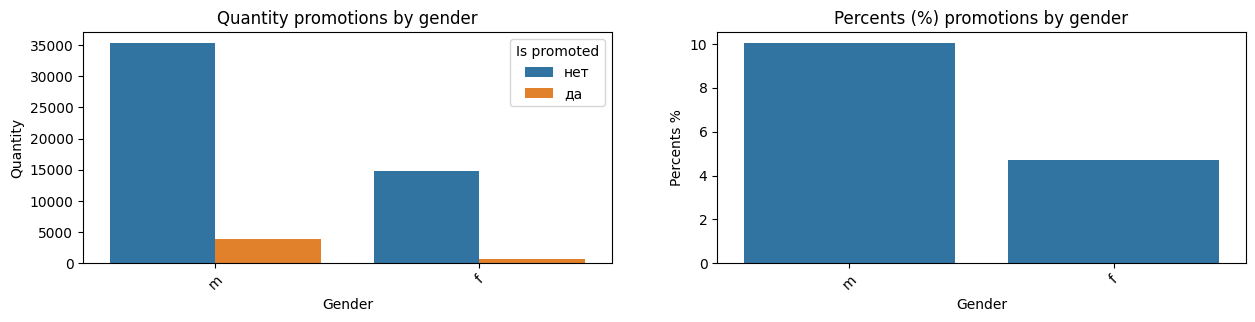

In [9]:
plot_promoted_counts(data = df_data, cat_column = 'gender', title_postfix = 'promotions by gender', x_label = 'Gender')

### Preprocess data for NN and split to train and test

In [10]:
label_encoders = {}
df_data_encoded = df_data.copy()
for column in ['department', 'region', 'education', 'gender', 'recruitment_channel']:
    le = LabelEncoder()
    df_data_encoded[column] = le.fit_transform(df_data_encoded[column])
    label_encoders[column] = le

# Normalize numeric features
scaler = StandardScaler()
df_data_encoded[['no_of_trainings', 'age', 'previous_year_rating', 'length_of_service', 'avg_training_score']] = scaler.fit_transform(
    df_data_encoded[['no_of_trainings', 'age', 'previous_year_rating', 'length_of_service', 'avg_training_score']]
)

# Separate features and labels
X = df_data_encoded.drop(['employee_id', 'is_promoted'], axis=1).values
y = df_data_encoded['is_promoted'].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32) 

X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32) 

In [17]:
# Separate group indices by protected attribute (gender)
protected_attribute_column_id = 3

female_class = (label_encoders['gender'].classes_ == 'f').argmax()
male_class = (label_encoders['gender'].classes_ == 'm').argmax()

female_indices = np.where(X_test[:, protected_attribute_column_id] == female_class)[0]
male_indices = np.where(X_test[:, protected_attribute_column_id] == male_class)[0]

In [12]:
class SimpleModel(nn.Module):
    def __init__(self, input_dim):
        super(SimpleModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 100)
        self.fc2 = nn.Linear(100, 1)
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x

In [42]:
model = SimpleModel(X_train.shape[1])
optimizer = optim.Adam(model.parameters(), lr=0.001)

objective = lambda input, pred, target: nn.BCELoss()(pred, target)
train_loop(model, optimizer, objective, X_train, y_train, X_test, y_test)

Epoch [1/3000], Train loss: 0.5603, Val loss: 0.5113
Epoch [501/3000], Train loss: 0.2210, Val loss: 0.2229
Epoch [1001/3000], Train loss: 0.2062, Val loss: 0.2111
Epoch [1501/3000], Train loss: 0.1971, Val loss: 0.2048
Epoch [2001/3000], Train loss: 0.1910, Val loss: 0.2021
Epoch [2501/3000], Train loss: 0.1863, Val loss: 0.1991


FPR balance -0.003157787313450969
FNR balance 0.06663960146490411


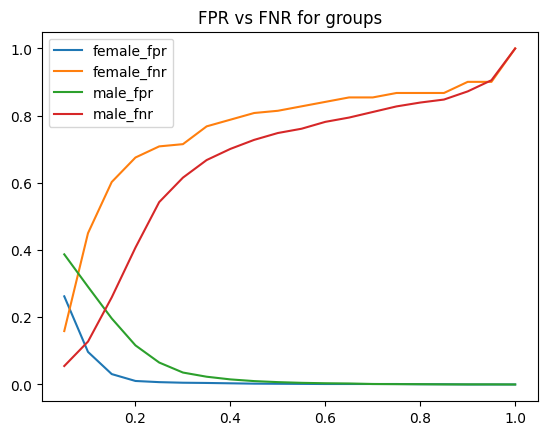

              precision    recall  f1-score   support

         0.0       0.93      0.99      0.96     10028
         1.0       0.80      0.24      0.37       934

    accuracy                           0.93     10962
   macro avg       0.87      0.62      0.67     10962
weighted avg       0.92      0.93      0.91     10962



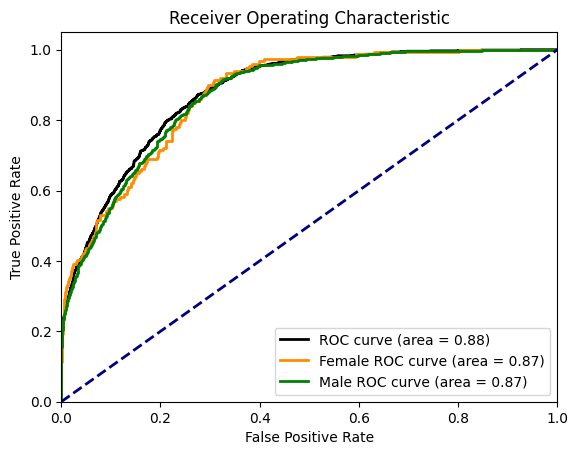

In [43]:
with torch.no_grad():
    model.eval()
    outputs = model(X_test)
    
y_true = y_test.detach().cpu().numpy()
y_score = outputs.detach().cpu().numpy()
    
plot_groups_fpr_fnr(y_true, y_score, female_indices, male_indices)
plot_roc_auc(y_true, y_score, female_indices, male_indices)

After fitting the model, the evaluation metrics indicate the following disparities between groups 'female' and 'male':

    False Positive Rate (FPR) Balance: -0.003157787313450969
    False Negative Rate (FNR) Balance: 0.06663960146490411

This imbalance in the false negative rates indicates that the model is not fair in its predictions, as one group experiences a higher rate of misclassification. This violates the principle of equalized odds, which requires that both false positive and false negative rates be equal across different groups.

### Lets introduce fair loss method that will equalize odds between groups

In [31]:
def fair_loss(y_pred, y_true, protected_attribute, lambda_fairness=1.0):
    bce_loss = nn.BCELoss()(y_pred, y_true)
    
    group_0_idx = (protected_attribute == 0).nonzero(as_tuple=True)[0]
    group_1_idx = (protected_attribute == 1).nonzero(as_tuple=True)[0]
    
    y_true_0, y_pred_0 = y_true[group_0_idx], y_pred[group_0_idx]
    y_true_1, y_pred_1 = y_true[group_1_idx], y_pred[group_1_idx]
    
    tpr_0 = (y_pred_0 * y_true_0).sum() / y_true_0.sum()
    tpr_1 = (y_pred_1 * y_true_1).sum() / y_true_1.sum()
    
    fpr_0 = (y_pred_0 * (1 - y_true_0)).sum() / (1 - y_true_0).sum()
    fpr_1 = (y_pred_1 * (1 - y_true_1)).sum() / (1 - y_true_1).sum()
    
    fairness_penalty = lambda_fairness * (torch.abs(tpr_0 - tpr_1) + torch.abs(fpr_0 - fpr_1))
    return bce_loss + fairness_penalty

model = SimpleModel(X_train.shape[1])
optimizer = optim.Adam(model.parameters(), lr=0.001)

objective = lambda input, pred, target: fair_loss(pred, target, input[:, protected_attribute_column_id], lambda_fairness=0.3)

train_loop(model, optimizer, objective, X_train, y_train, X_test, y_test)

Epoch [1/3000], Train loss: 0.8507, Val loss: 0.7720
Epoch [501/3000], Train loss: 0.2324, Val loss: 0.2398
Epoch [1001/3000], Train loss: 0.2171, Val loss: 0.2255
Epoch [1501/3000], Train loss: 0.2111, Val loss: 0.2193
Epoch [2001/3000], Train loss: 0.2073, Val loss: 0.2141
Epoch [2501/3000], Train loss: 0.2041, Val loss: 0.2113


FPR balance -0.0025983467540104097
FNR balance 0.001505501848045765


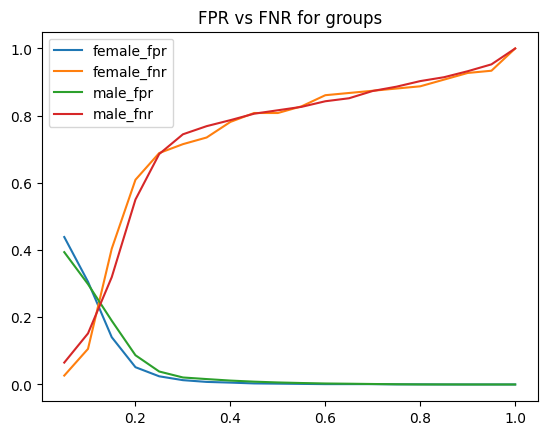

              precision    recall  f1-score   support

         0.0       0.93      1.00      0.96     10028
         1.0       0.78      0.19      0.30       934

    accuracy                           0.93     10962
   macro avg       0.85      0.59      0.63     10962
weighted avg       0.92      0.93      0.90     10962



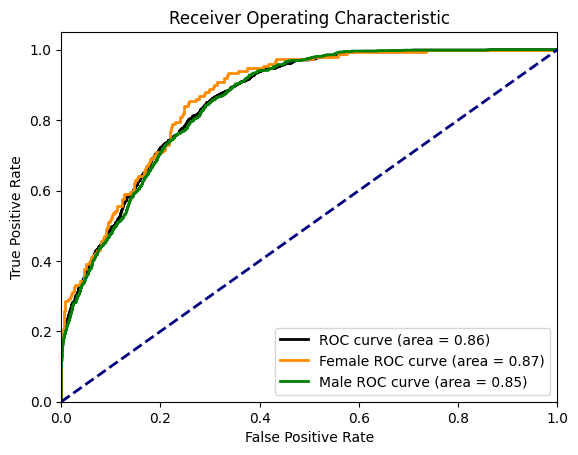

In [36]:
with torch.no_grad():
    model.eval()
    outputs = model(X_test)
    
y_true = y_test.detach().cpu().numpy()
y_score = outputs.detach().cpu().numpy()
    
plot_groups_fpr_fnr(y_true, y_score, female_indices, male_indices)
plot_roc_auc(y_true, y_score, female_indices, male_indices)

## Conclusion

After implementing the solution for equalized odds, the evaluation metrics indicate the following balances between groups 'female' and 'male':

    False Positive Rate (FPR) Balance: -0.0025983467540104097
    False Negative Rate (FNR) Balance: 0.001505501848045765

The updated metrics show significant improvement in the fairness of the model:
These values suggest that the model now treats both groups almost equally in terms of error rates. The near-zero FPR and FNR balances indicate that the model's predictions are fair, with minimal disparity between the groups.

In conclusion, the introduction of the solution for equalized odds has successfully reduced the imbalances in error rates between groups 'female' and 'male'. The model now adheres more closely to the principle of equalized odds, ensuring fairer predictions across all groups.